In [1]:
import datasets

In [3]:
# Configs
DATASET = "bergr7/weakly_supervised_ag_news"
TRANSFORMER_MODEL = "distilbert-base-uncased"
LABELS = datasets.load_dataset('ag_news')["train"].features["label"].names
NUM_SAMPLES = 5

/opt/conda/envs/notebook-env/lib/python3.8/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Using custom data configuration default
Found cached dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
ag_news_data = datasets.load_dataset(DATASET)

Using custom data configuration bergr7--weakly_supervised_ag_news-4dbef0c6a5e5ed58
Found cached dataset csv (/root/.cache/huggingface/datasets/bergr7___csv/bergr7--weakly_supervised_ag_news-4dbef0c6a5e5ed58/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
ag_news_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 37340
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 24000
    })
})

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL)

# Helper function to tokenize the input text
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize dataset
data_tokenized = ag_news_data.map(tokenize, batched=True, remove_columns=["text"])
# Set convenient output format
data_tokenized.set_format("torch")

Loading cached processed dataset at /root/.cache/huggingface/datasets/bergr7___csv/bergr7--weakly_supervised_ag_news-4dbef0c6a5e5ed58/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-b9a7b45fb7ee05f0.arrow


  0%|          | 0/8 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/bergr7___csv/bergr7--weakly_supervised_ag_news-4dbef0c6a5e5ed58/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-29d78f1979ef088a.arrow


In [7]:
from small_text.integrations.transformers import TransformersDataset
from small_text.base import LABEL_UNLABELED


# Create tuples from the tokenized training data
data = [
    # Need to add an extra dimension to indicate a batch size of 1 -> [None]
    (row["input_ids"][None], row["attention_mask"][None], LABEL_UNLABELED)
    for row in data_tokenized["train"]
]

# Create the dataset for small-text
dataset = TransformersDataset(data)

/opt/conda/envs/notebook-env/lib/python3.8/site-packages/small_text/data/datasets.py:29: UserWarning: Passing target_labels=None is discouraged as it can lead to unintended results in combination with indexing and cloning. Moreover, explicit target labels might be required in the next major version.
  warnings.warn('Passing target_labels=None is discouraged as it can lead to '


In [13]:
len(dataset.data)

37340

In [10]:
# Create validation dataset
data_test = [
    (row["input_ids"][None], row["attention_mask"][None], int(row["label"]))
    for row in data_tokenized["validation"]
]
dataset_test = TransformersDataset(data_test)

In [11]:
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.integrations.transformers import TransformerModelArguments
from small_text.query_strategies import LeastConfidence
from small_text.active_learner import PoolBasedActiveLearner


# Define our classifier
clf_factory = TransformerBasedClassificationFactory(
    TransformerModelArguments(TRANSFORMER_MODEL),
    num_classes=4,
    # If you have a cuda device, specify it here.
    # Otherwise, just remove the following line.
    kwargs={"device": "cuda"}
)

# Define our query strategy
query_strategy = LeastConfidence()

# Use the active learner with a pool containing all unlabeled data
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

In [12]:
from small_text.initialization import random_initialization
import numpy as np

np.random.seed(42)


# Number of samples in our queried batches
NUM_SAMPLES = 5

# Randomly draw an initial subset from the data pool
initial_indices = random_initialization(dataset, NUM_SAMPLES)

In [13]:
initial_indices

array([30992,  8317, 17797, 23232, 12463])

In [14]:
import rubrix as rb

rb.init(api_url="http://rubrix:80")

Cannot find required package for logging.
Please, install `loguru` by typing:
pip install loguru
if you want to enable enhanced logging


In [15]:
# Choose a name for the dataset
DATASET_NAME = "test_with_active_learning_test"

# Define labeling schema
settings = rb.TextClassificationSettings(label_schema=LABELS)

# Create dataset with a label schema
rb.configure_dataset(name=DATASET_NAME, settings=settings)

# Create records from the initial batch
records = [
    rb.TextClassificationRecord(
        text=ag_news_data["train"]["text"][idx],
        metadata={"batch_id": 0},
        id=idx,
    )
    for idx in initial_indices
]

# Log initial records to Rubrix
rb.log(records, DATASET_NAME)

  0%|          | 0/5 [00:00<?, ?it/s]

5 records logged to http://rubrix:80/datasets/rubrix/test_with_active_learning_test


BulkResponse(dataset='test_with_active_learning_test', processed=5, failed=0)

In [16]:
records[0]

TextClassificationRecord(text='Baseball and its fans recover from 1994 strike Ten years after the World Series was canceled and fans left in droves, Major League Baseball will tell you it has never been healthier.', inputs={'text': 'Baseball and its fans recover from 1994 strike Ten years after the World Series was canceled and fans left in droves, Major League Baseball will tell you it has never been healthier.'}, prediction=None, prediction_agent=None, annotation=None, annotation_agent=None, multi_label=False, explanation=None, id=30992, metadata={'batch_id': 0}, status='Default', event_timestamp=None, metrics=None, search_keywords=None)

In [17]:
from rubrix.listeners import listener
from sklearn.metrics import accuracy_score

# Define some helper variables
# LABEL2INT = ag_news_data["train"].features["label"].str2int
LABEL2INT = dict(zip(LABELS, range(4)))
ACCURACIES = []

# Set up the active learning loop with the listener decorator
@listener(
    dataset=DATASET_NAME,
    query="status:Validated AND metadata.batch_id:{batch_id}",
    condition=lambda search: search.total==NUM_SAMPLES,
    execution_interval_in_seconds=3,
    batch_id=0
)
def active_learning_loop(records, ctx):

    # 1. Update active learner
    print(f"Updating with batch_id {ctx.query_params['batch_id']} ...")
    print('Please go to rubrix to label the data...')
    y = np.array([LABEL2INT[rec.annotation] for rec in records])
    
    print(f"{NUM_SAMPLES} records have been labeled updating active learner...")
    # initial update
    if ctx.query_params["batch_id"] == 0:
        indices = np.array([rec.id for rec in records])
        active_learner.initialize_data(indices, y)
    # update with the prior queried indices
    else:
        active_learner.update(y)
    print("Done!")
    

    # 2. Query active learner
    print("Querying new data points ...")
    queried_indices = active_learner.query(num_samples=NUM_SAMPLES)
    ctx.query_params["batch_id"] += 1
    new_records = [
        rb.TextClassificationRecord(
            text=ag_news_data["train"]["text"][idx],
            metadata={"batch_id": ctx.query_params["batch_id"]},
            id=idx,
        )
        for idx in queried_indices
    ]

    # 3. Log the batch to Rubrix
    rb.log(new_records, DATASET_NAME)

    # 4. Evaluate current classifier on the test set
    print("Evaluating current classifier ...")
    accuracy = accuracy_score(
        dataset_test.y,
        active_learner.classifier.predict(dataset_test),
    )
    ACCURACIES.append(accuracy)
    print("Done!")

    print("Waiting for annotations ...")

In [18]:
active_learning_loop.start()

Updating with batch_id 0 ...
Please go to rubrix to label the data...
5 records have been labeled updating active learner...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the f

  0%|          | 0/5 [00:00<?, ?it/s]

5 records logged to http://rubrix:80/datasets/rubrix/test_with_active_learning_test
Evaluating current classifier ...
Done!
Waiting for annotations ...
Updating with batch_id 1 ...
Please go to rubrix to label the data...
5 records have been labeled updating active learner...


/opt/conda/envs/notebook-env/lib/python3.8/site-packages/small_text/data/datasets.py:29: UserWarning: Passing target_labels=None is discouraged as it can lead to unintended results in combination with indexing and cloning. Moreover, explicit target labels might be required in the next major version.
  warnings.warn('Passing target_labels=None is discouraged as it can lead to '


Done!
Querying new data points ...


  0%|          | 0/5 [00:00<?, ?it/s]

5 records logged to http://rubrix:80/datasets/rubrix/test_with_active_learning_test
Evaluating current classifier ...
Done!
Waiting for annotations ...


In [19]:
active_learning_loop.stop()

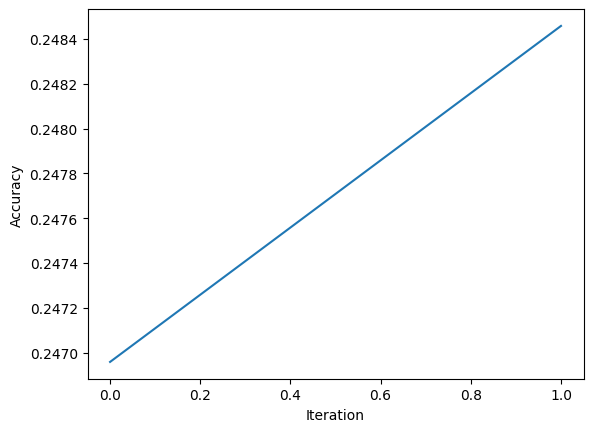

In [20]:
import pandas as pd

pd.Series(ACCURACIES).plot(xlabel="Iteration", ylabel="Accuracy");

In [21]:
ACCURACIES

[0.24695833333333334, 0.24845833333333334]

In [22]:
active_learner.classifier

In [47]:
rb.load(DATASET_NAME).to_datasets()[0]

{'text': 'Musharraf ally elected as new Pakistan PM ISLAMABAD - Pakistan #39;s Parliament elected former Finance Minister Shaukat Aziz as Prime Minister yesterday amid an opposition boycott of the vote.',
 'inputs': {'text': 'Musharraf ally elected as new Pakistan PM ISLAMABAD - Pakistan #39;s Parliament elected former Finance Minister Shaukat Aziz as Prime Minister yesterday amid an opposition boycott of the vote.'},
 'prediction': None,
 'prediction_agent': None,
 'annotation': 'World',
 'annotation_agent': 'rubrix',
 'multi_label': False,
 'explanation': None,
 'id': '1813',
 'metadata': {'batch_id': 1},
 'status': 'Validated',
 'event_timestamp': None,
 'metrics': {'text_length': 192}}